# Titanic Survival Analysis
- The Titanic dataset is a well-known dataset used for classification tasks, particularly for predicting survival outcomes. It contains information on passengers aboard the Titanic when it sank in 1912.
### Dataset Columns
- The Titanic dataset typically includes the following columns:
1. PassengerId – Unique identifier for each passenger
2. Survived – Survival status (0 = No, 1 = Yes)
3. Pclass – Ticket class (1 = First, 2 = Second, 3 = Third)
4. Name – Passenger’s full name
5. Sex – Gender (male/female)
6. Age – Age of the passenger
7. SibSp – Number of siblings/spouses aboard
8. Parch – Number of parents/children aboard
9. Ticket – Ticket number
10. Fare – Passenger fare
11. Cabin – Cabin number (often missing)
12. Embarked – Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Data Preprocessing and Cleaning

In [5]:
import os
import psycopg2  # Use pymysql or psycopg2 for PostgreSQL
from dotenv import load_dotenv
import pyforest
import warnings

warnings.filterwarnings('ignore')

In [6]:
# Load environment variables from .env file
load_dotenv()

# Fetch credentials
DB_HOST = os.getenv("DB_HOST", "172.178.131.221")
DB_USER = os.getenv("DB_USER", "luxds")
DB_PASSWORD = os.getenv("DB_PASSWORD", "1234")
DB_NAME = os.getenv("DB_NAME", "postgres")
DB_PORT = os.getenv("DB_PORT", "5432")

# Connect to MySQL Database
try:
    conn = psycopg2.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME,
        port= DB_PORT
    )
    cursor = conn.cursor()

    # Execute SQL Query
    cursor.execute("SELECT * FROM ds.titanicdata LIMIT 10;")  # Adjust table name
    rows = cursor.fetchall()

    # Print fetched data
    for row in rows:
        print(row)

except Exception as e:
    print(f"Error: {e}")

(1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, '', 'S')
(2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833, 'C85', 'C')
(3, 1, 3, 'Heikkinen, Miss. Laina', 'female', 26.0, 0, 0, 'STON/O2. 3101282', 7.925, '', 'S')
(4, 1, 1, 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'female', 35.0, 1, 0, '113803', 53.1, 'C123', 'S')
(5, 0, 3, 'Allen, Mr. William Henry', 'male', 35.0, 0, 0, '373450', 8.05, '', 'S')
(6, 0, 3, 'Moran, Mr. James', 'male', None, 0, 0, '330877', 8.4583, '', 'Q')
(7, 0, 1, 'McCarthy, Mr. Timothy J', 'male', 54.0, 0, 0, '17463', 51.8625, 'E46', 'S')
(8, 0, 3, 'Palsson, Master. Gosta Leonard', 'male', 2.0, 3, 1, '349909', 21.075, '', 'S')
(9, 1, 3, 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)', 'female', 27.0, 0, 2, '347742', 11.1333, '', 'S')
(10, 1, 2, 'Nasser, Mrs. Nicholas (Adele Achem)', 'female', 14.0, 1, 0, '237736', 30.0708, '', 'C')


In [7]:
  # Load data into a Pandas DataFrame
query = "SELECT * FROM ds.titanicdata;"
df = pd.read_sql(query, conn)
df.head()


<IPython.core.display.Javascript object>

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S


### Data Exploration and cleaning

In [8]:
# checking infomation about the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        891 non-null    object 
 11  embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# descriptive analysis of the data
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
# checking for null values
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin            0
embarked         0
dtype: int64

In [11]:
# checking mean data
df_mean = np.mean(df['age'])
mean_age = np.round(df_mean)
mean_age

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

np.float64(30.0)

In [12]:
# filling in age by the mean
df['age'] = df['age'].fillna(mean_age)
df['age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: age, dtype: float64

In [13]:
# checking for null values
df.isnull().sum()

passengerid    0
survived       0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
dtype: int64

In [14]:
# Show unique values in the Cabin column (only first 20 for readability)
print(df["cabin"].unique()[:20])

['' 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12']


In [15]:
# Replace empty strings and spaces with NaN
df["cabin"] = df["cabin"].replace(r'^\s*$', np.nan, regex=True)

# Now check for null values
print(df["cabin"].isnull().sum())

<IPython.core.display.Javascript object>

687


In [16]:
# checking for null values for cabin column
df['cabin'].isnull().sum()

np.int64(687)

In [17]:
# filling in the missing values of the cabin using the ticket
df["cabin"] = df.groupby("ticket")["cabin"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown"))
df['cabin'].head(100)

0     Unknown
1         C85
2     Unknown
3        C123
4     Unknown
       ...   
95    Unknown
96         A5
97    D10 D12
98    Unknown
99    Unknown
Name: cabin, Length: 100, dtype: object

In [18]:
# checking for duplicates
df.duplicated().sum()

np.int64(0)

In [19]:
# Dropping unimportant features
drop_list = ['name', 'ticket', 'cabin', 'passengerid']
df_cleaned = df.drop(drop_list, axis=1)
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
df_cleaned.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Performing EDA 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

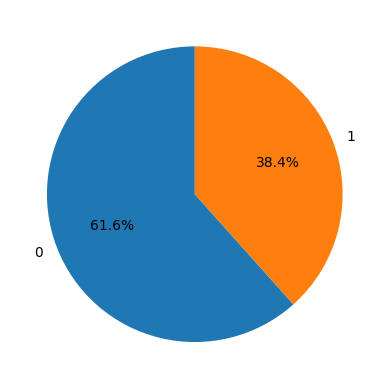

In [28]:
# Ratio of people who survived and those who didn't
survived_counts = df_cleaned['survived'].value_counts()
plt.pie(survived_counts, labels=survived_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

In [40]:
# Total number of passengers per pclass
total_passengers_by_pclass = df_cleaned.groupby('pclass')['survived'].count()
print(total_passengers_by_pclass)

pclass
1    216
2    184
3    491
Name: survived, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

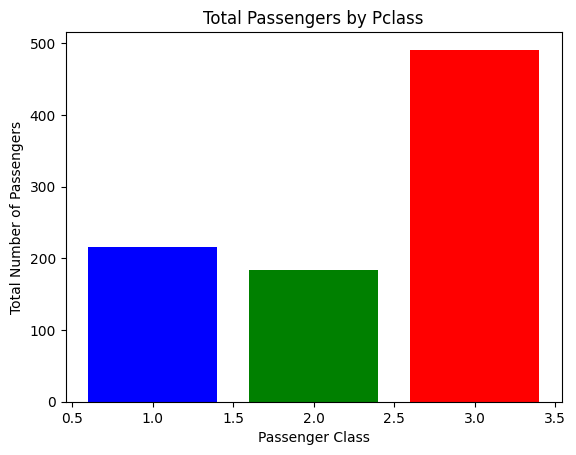

In [41]:
# Plot the bar chart
plt.bar(total_passengers_by_pclass.index, total_passengers_by_pclass, color=['blue', 'green', 'red'])

# Labels and title
plt.xlabel("Passenger Class")
plt.ylabel("Total Number of Passengers")
plt.title("Total Passengers by Pclass")

# Show the plot
plt.show()


### Key Insights
1. Many people aboard the ship were from the 3rd class and located in the lower part of the ship.
2. 

In [42]:
# checking the total number of people who survived and who didn't
survival_pclass = df_cleaned.groupby('pclass')['survived'].value_counts().unstack()

print(survival_pclass)


survived    0    1
pclass            
1          80  136
2          97   87
3         372  119


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

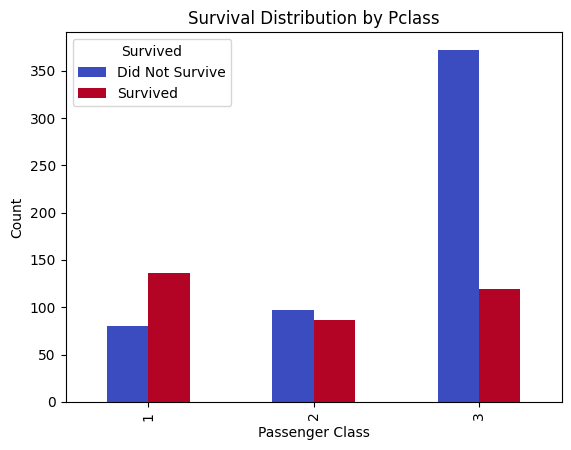

In [47]:
# Plotting the distribution
survival_pclass.plot(kind='bar', colormap='coolwarm')

# Show the plot
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.title("Survival Distribution by Pclass")
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])
plt.show()


### Key Insights
1. Many people from pclass 1 survived, this could be either they were near the life boats or were given first priority
2. A lot of people in pclass 3 didn't survive the ship sink, this could be either the cabins they were in or they at the lower part of the ship.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

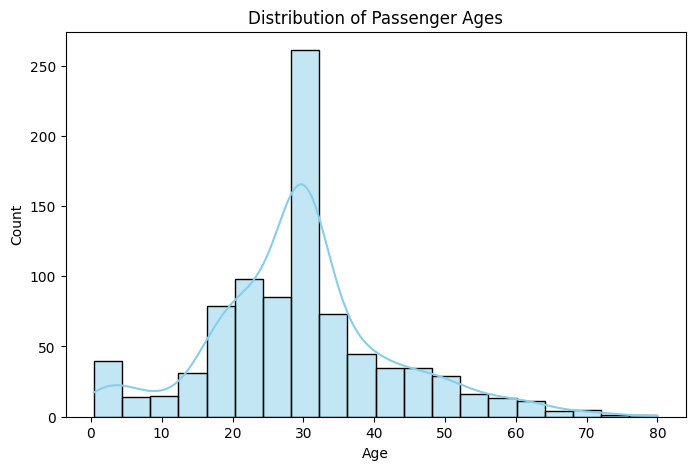

In [54]:
# Plot histogram for Distribution of Passenger Ages
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['age'], bins=20, kde=True, color='skyblue')

# Labels & Title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Passenger Ages')

plt.show()


In [53]:
# checking the age distribution
total_number_per_age = df_cleaned.groupby('age')['survived'].value_counts().unstack()
total_number_per_age

survived,0,1
age,,
0.42,NaN,1.0
0.67,NaN,1.0
0.75,NaN,2.0
0.83,NaN,2.0
0.92,NaN,1.0
...,...,...
70.00,2.0,NaN
70.50,1.0,NaN
71.00,2.0,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

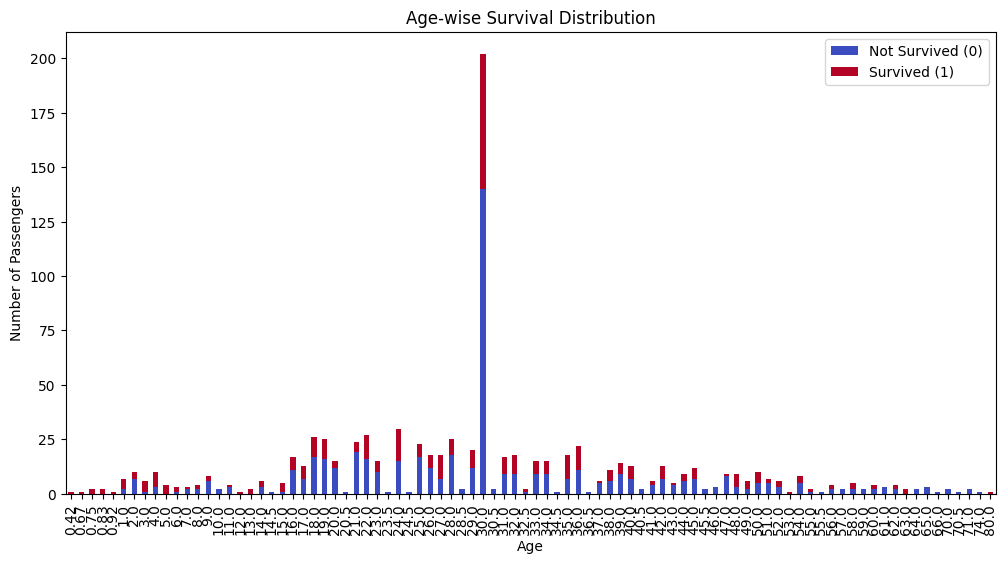

In [57]:
# Plot
total_number_per_age.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Labels & Title
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.title('Age-wise Survival Distribution')
plt.legend(['Not Survived (0)', 'Survived (1)'])

plt.show()


In [60]:
# fare distribution per pclass
fare_by_pclass = df.groupby('pclass')['fare'].sum()
fare_by_pclass


pclass
1    18177.4125
2     3801.8417
3     6714.6951
Name: fare, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

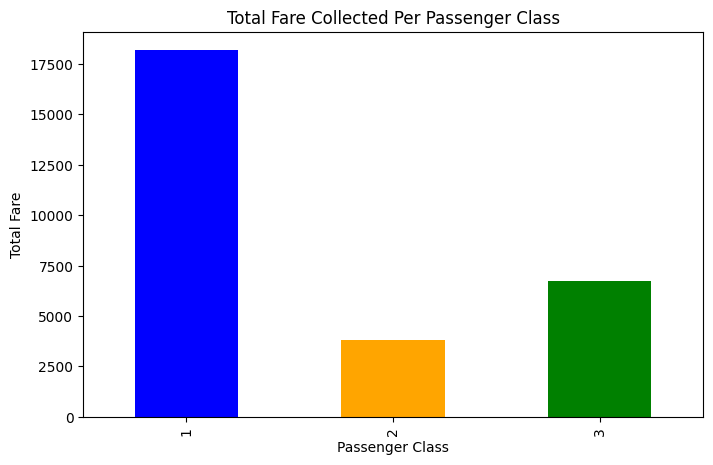

In [64]:
fare_by_pclass.plot(kind='bar', color=['blue', 'orange', 'green'], figsize=(8, 5))

plt.xlabel('Passenger Class')
plt.ylabel('Total Fare')
plt.title('Total Fare Collected Per Passenger Class')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

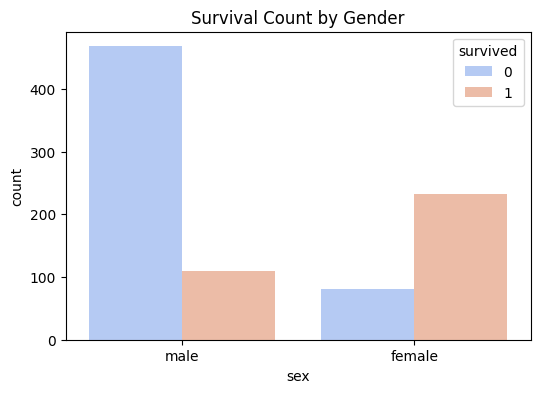

In [62]:
# gender rates on the people 
plt.figure(figsize=(6, 4))
sns.countplot(x= df_cleaned['sex'], hue=df_cleaned['survived'], data=df, palette='coolwarm')
plt.title('Survival Count by Gender')
plt.show()

### Key Insights
- Passangers who died most were men and women are the ones who survived most

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

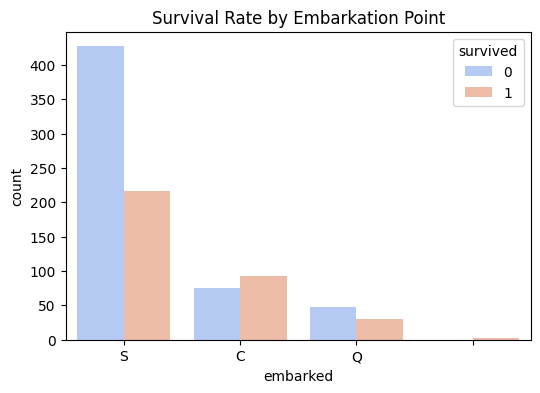

In [65]:
# Survival Rate by Embarkation Point
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned['embarked'], hue=df_cleaned['survived'], data=df, palette='coolwarm')
plt.title('Survival Rate by Embarkation Point')
plt.show()

### Key Insights
1. A lot Passengers from Southampton (S) passed 
2. 🔹 Passengers from Southampton (S) had better survival chances.